In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import numpy as np
from photutils import centroid_com
from astropy.modeling import models, fitting
from scipy import asarray as ar,exp



# This notebook examines results from coadd run on catch-22-1 target observed in the fitsfiles folder
### Folders inside 'reductions/p200_dbsp_red_A':
- __Science__: these are fits datatables
- __QA__: png image files showing residuals etc. for wl solution
- __Masters__: fits images of arcs,bias,flats,tilt,wlcalib, etc.


__Science__ requires work to understand;
__QA__ can be opened as a photo; 
__Masters__ can be opened with ds9

# Science folder -------------------------------------------------
### One file exploration

### generalize to examine all files
## Science 1d & 2d _.fits_ files

In [2]:
# print all filenames
dim_options = ['1d', '2d'] #only 1d have .txt options
number_options = [ '099', '100', '101', '102', ] #original obs. log number
end_options = ['T112357.399','T112740.547','T113123.686','T113555.356'] #all beyond June16..until ext
ext_options = ['.fits','.txt'] #only 1d have .txt options and this code wont open .txt files
all_fns =[]; fns_2d = []
print('all file names:')
for i in range(len(number_options)):
    #establish filename for 2d options
    specD = dim_options[1]
    fnumber = number_options[i]
    fend =  end_options[i]
    ext = ext_options[0]
    filename = 'spec{}_red0{}-79005021831220-Catch22_DBSPr_2017May18{}{}'.format(specD,fnumber,fend,ext)
    print('{}.'.format(i),filename)
    all_fns.append(filename)
    fns_2d.append(filename)
    #establish filename for 1d options
    specD = dim_options[0]
    fnumber = number_options[i]
    fend =  end_options[i]
    ext = ext_options[0] #fits first
    filename = '   spec{}_red0{}-79005021831220-Catch22_DBSPr_2017May18{}{}'.format(specD,fnumber,fend,ext)
    if i !=1: #b/c 100.fits only has 2D
        print(filename)
        all_fns.append(filename)
        ext = ext_options[1] #txt second
        filename = '   spec{}_red0{}-79005021831220-Catch22_DBSPr_2017May18{}{}'.format(specD,fnumber,fend,ext)
        print(filename)
        all_fns.append(filename)
    else:
        pass

all file names:
0. spec2d_red0099-79005021831220-Catch22_DBSPr_2017May18T112357.399.fits
   spec1d_red0099-79005021831220-Catch22_DBSPr_2017May18T112357.399.fits
   spec1d_red0099-79005021831220-Catch22_DBSPr_2017May18T112357.399.txt
1. spec2d_red0100-79005021831220-Catch22_DBSPr_2017May18T112740.547.fits
2. spec2d_red0101-79005021831220-Catch22_DBSPr_2017May18T113123.686.fits
   spec1d_red0101-79005021831220-Catch22_DBSPr_2017May18T113123.686.fits
   spec1d_red0101-79005021831220-Catch22_DBSPr_2017May18T113123.686.txt
3. spec2d_red0102-79005021831220-Catch22_DBSPr_2017May18T113555.356.fits
   spec1d_red0102-79005021831220-Catch22_DBSPr_2017May18T113555.356.fits
   spec1d_red0102-79005021831220-Catch22_DBSPr_2017May18T113555.356.txt


In [3]:
all_fns

['spec2d_red0099-79005021831220-Catch22_DBSPr_2017May18T112357.399.fits',
 '   spec1d_red0099-79005021831220-Catch22_DBSPr_2017May18T112357.399.fits',
 '   spec1d_red0099-79005021831220-Catch22_DBSPr_2017May18T112357.399.txt',
 'spec2d_red0100-79005021831220-Catch22_DBSPr_2017May18T112740.547.fits',
 'spec2d_red0101-79005021831220-Catch22_DBSPr_2017May18T113123.686.fits',
 '   spec1d_red0101-79005021831220-Catch22_DBSPr_2017May18T113123.686.fits',
 '   spec1d_red0101-79005021831220-Catch22_DBSPr_2017May18T113123.686.txt',
 'spec2d_red0102-79005021831220-Catch22_DBSPr_2017May18T113555.356.fits',
 '   spec1d_red0102-79005021831220-Catch22_DBSPr_2017May18T113555.356.fits',
 '   spec1d_red0102-79005021831220-Catch22_DBSPr_2017May18T113555.356.txt']

In [4]:
fns_2d

['spec2d_red0099-79005021831220-Catch22_DBSPr_2017May18T112357.399.fits',
 'spec2d_red0100-79005021831220-Catch22_DBSPr_2017May18T112740.547.fits',
 'spec2d_red0101-79005021831220-Catch22_DBSPr_2017May18T113123.686.fits',
 'spec2d_red0102-79005021831220-Catch22_DBSPr_2017May18T113555.356.fits']

# Science 2d spectra -- Attempt to do Halpha trace using pypeit reduced 2d file

In [5]:
#test opening pypeit reduced 2d image
using_file = fns_2d[1]
start_path = 'coadd2D_test/reductions/p200_dbsp_red_A/Science/'
# image_file = '{}spec2d_red0099-79005021831220-Catch22_DBSPr_2017May18T112357.399.fits'.format(start_path)
image_file = '{}{}'.format(start_path,using_file)
image_data = fits.getdata(image_file)
print(using_file)
print(type(image_data))
print(image_data.shape)

spec2d_red0100-79005021831220-Catch22_DBSPr_2017May18T112740.547.fits
<class 'numpy.ndarray'>
(4114, 440)


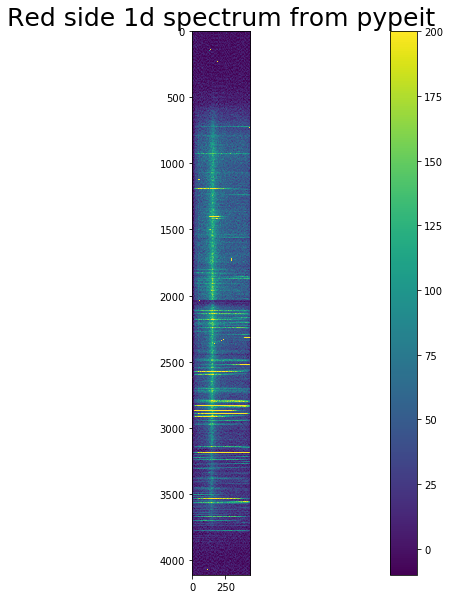

In [6]:
plt.figure(figsize=(50,10))
plt.imshow(image_data, vmin=-10, vmax =200 ,cmap='viridis')
plt.colorbar();plt.title('Red side 1d spectrum from pypeit',fontsize=25);

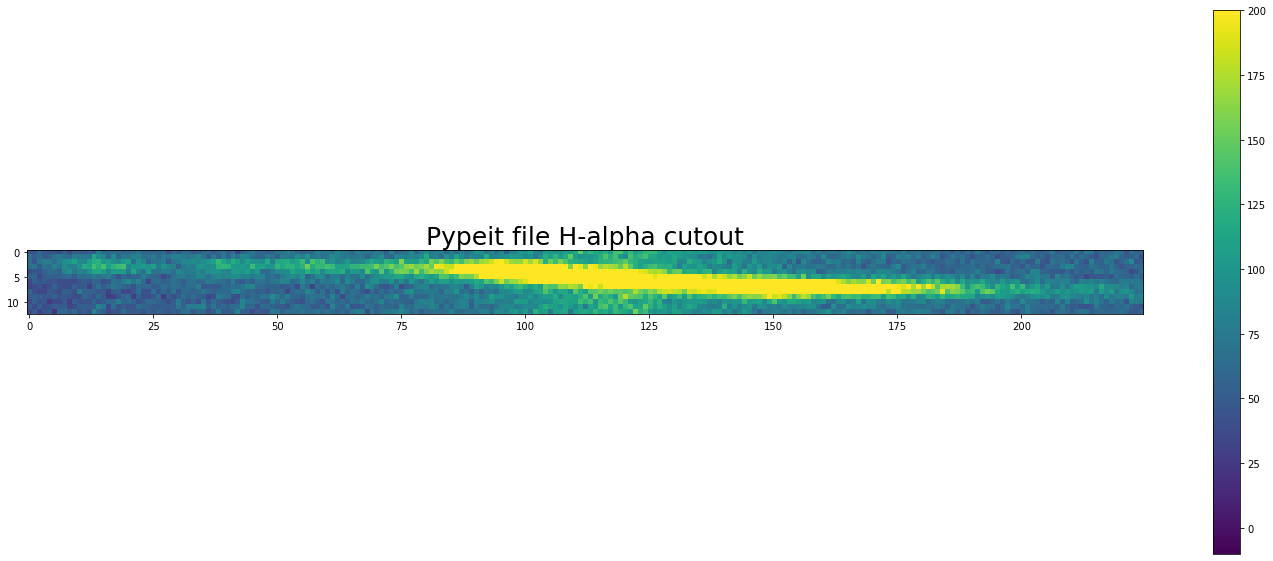

In [7]:
#gonna try to slice out h-alpha

#spectral axis 
ha_lowerlim = 1396
ha_upperlim = 1409
#positional axis
target_lowerlim = 35
target_upperlim = 260
#select ha
ha_only = image_data[ha_lowerlim: ha_upperlim, target_lowerlim: target_upperlim ] #[wl,pos] is opposite to my version
#plot ha
plt.figure(figsize=(25,10))
plt.imshow(ha_only, vmin=-10, vmax =200 ,cmap='viridis')
plt.title('Pypeit file H-alpha cutout',fontsize=25)
plt.colorbar();

Transposed data to get it to work with my previous code 
since my reduction expects vertical orientation but pypeit does something to give horizontal


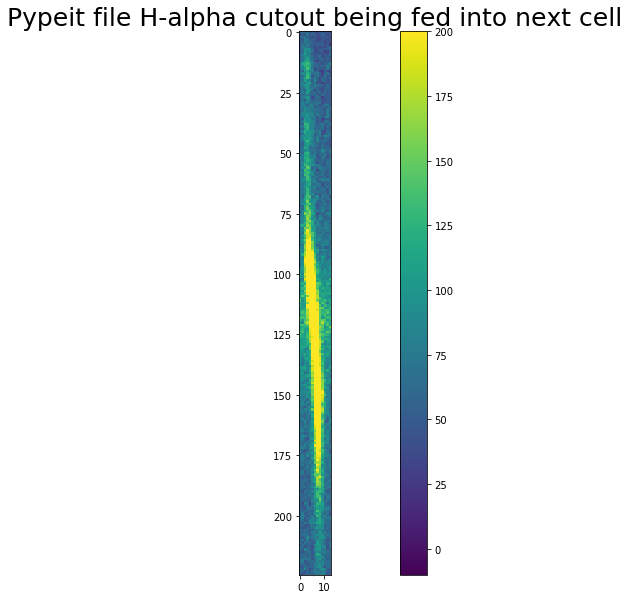

In [8]:
type(image_data),image_data.shape

print('Transposed data to get it to work with my previous code',
      '\nsince my reduction expects vertical orientation but pypeit does something to give horizontal')
#see what data goes into the centroid for loop in next cell
new_short = image_data[1396:1409,35:260] #had to switch to [wl,pos] order again; mine used[pos,wl]
plt.figure(figsize=(25,10))
plt.imshow(np.transpose(new_short), vmin=-10, vmax =200 ,cmap='viridis')
plt.title('Pypeit file H-alpha cutout being fed into next cell',fontsize=25)
plt.colorbar();

(225, 13)


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.asarray is deprecated and will be removed in SciPy 2.0.0, use numpy.asarray instead


(1398, 1415)

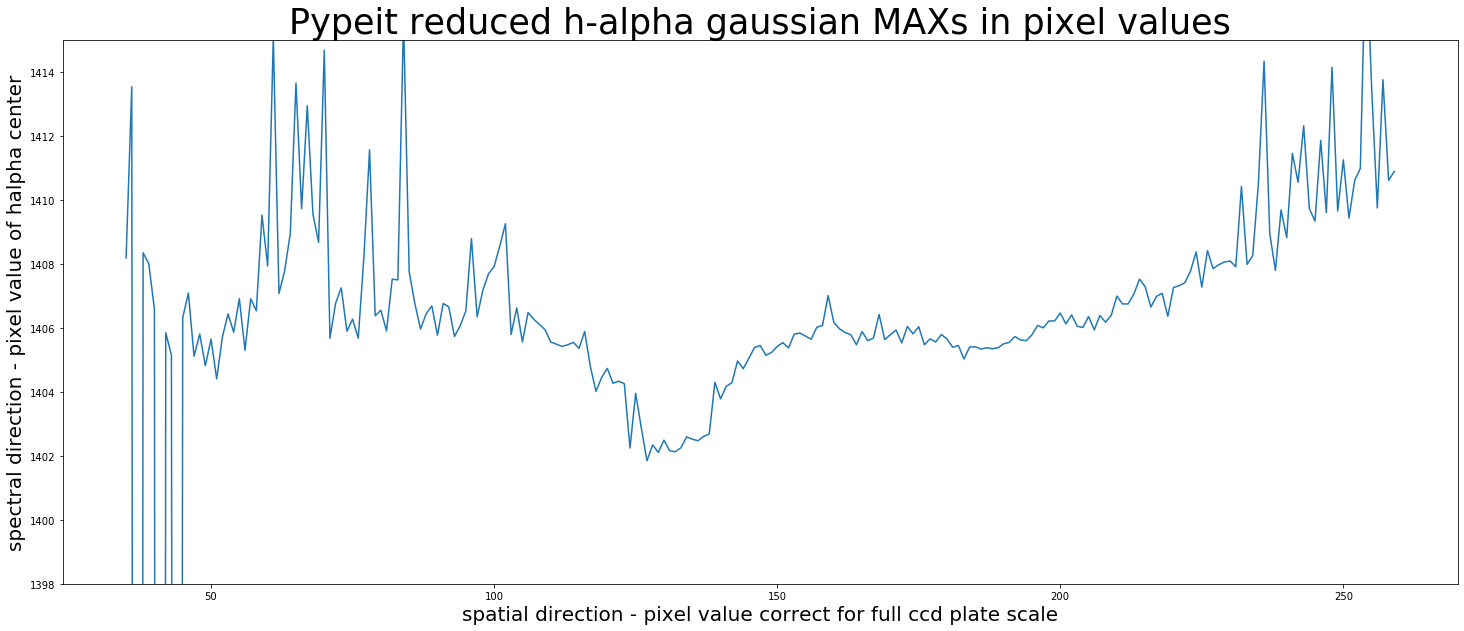

In [9]:
#try to do a centroid on this to see if looks like mine

#transposed to get my code to work b/c of my original orientation: me=vertical; pypeit=horizontal
new_short = np.transpose(image_data[1396:1409,35:260]) #had to switch to [wl,pos] order again; mine used[pos,wl]
print(np.shape(new_short))

#gets halpha centroids/gaussians/uncertainities in target gal's range
mylist_ys2=[];centroids_pix=[];gfit_vals=[];stddev=[];means=[];means_unc=[]
for count,row in enumerate(new_short): 
#     print('big test:',row)
    #calculates centroids per row
    flux_fake2d2 = row[:,np.newaxis] #makes each row array into a fake2d
    centroid_ys, centroid_xs = centroid_com(flux_fake2d2)#finds center(x,y) of halpha for each row array
    mylist_ys2.append(centroid_ys)
#     print(centroid_xs, centroid_ys,len(row))
    centroids_pix.append(centroid_xs) #collects all halpha centroids per row
    
    #calculating errors per row via gaussian fit
    x = ar(range(len(row)))
    y = row
    mean = centroid_xs
    g_init = models.Gaussian1D(amplitude=max(y), mean=mean, stddev=2.)
    fit_g = fitting.LevMarLSQFitter()
    gaussian = fit_g(g_init, x, y)
    gfit_vals.append(gaussian)
    stddev.append(gaussian.stddev.value)
    means.append(gaussian.mean.value)

    #trying to get uncertainities per row via covariance matrix
    gaussian.param_cov = fit_g.fit_info['param_cov']
    means_unc.append(fit_g.fit_info['param_cov'])
    #means_unc.append(fit_g.fit_info['param_cov'][1][1]) #if throws error use line above instead
#     print('this is fit_g:',fit_g)
#     print('this is fit_info:',fit_g.fit_info)
#     if count == 10:
#         break
#     else:
#         continue


    
#end of for loop  - making things into arrays so easier to work with  
centroids_pix=np.array(centroids_pix) #halpha centroids (wl) array
gfit_vals = np.array(gfit_vals)  #all gaussian outputs in pixels
stddev = np.array(stddev) #std of gaussians in pixels
means = np.array(means) #gaussian peaks in pixels


#just changing varaiables for plotting ease
ha_range_correction = 1396
space_pix_correction = 35
centroid_specpix_fullccd = centroids_pix + ha_range_correction
gaussmax_specpix_fullccd = means + stddev + ha_range_correction
gauss_mean = means + ha_range_correction
target_spacepix_fullccd = np.arange(len(centroids_pix)) +space_pix_correction

#plot results

#plotting
plt.figure(figsize=(25,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of halpha center',fontsize=20)
plt.plot(target_spacepix_fullccd,gaussmax_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
plt.title('Pypeit reduced h-alpha gaussian MAXs in pixel values',fontsize=35)
#plt.ylim(1393,1407)
plt.ylim(1398,1415)

well that hump around x=130 in the gaussMAXs is from the stddev


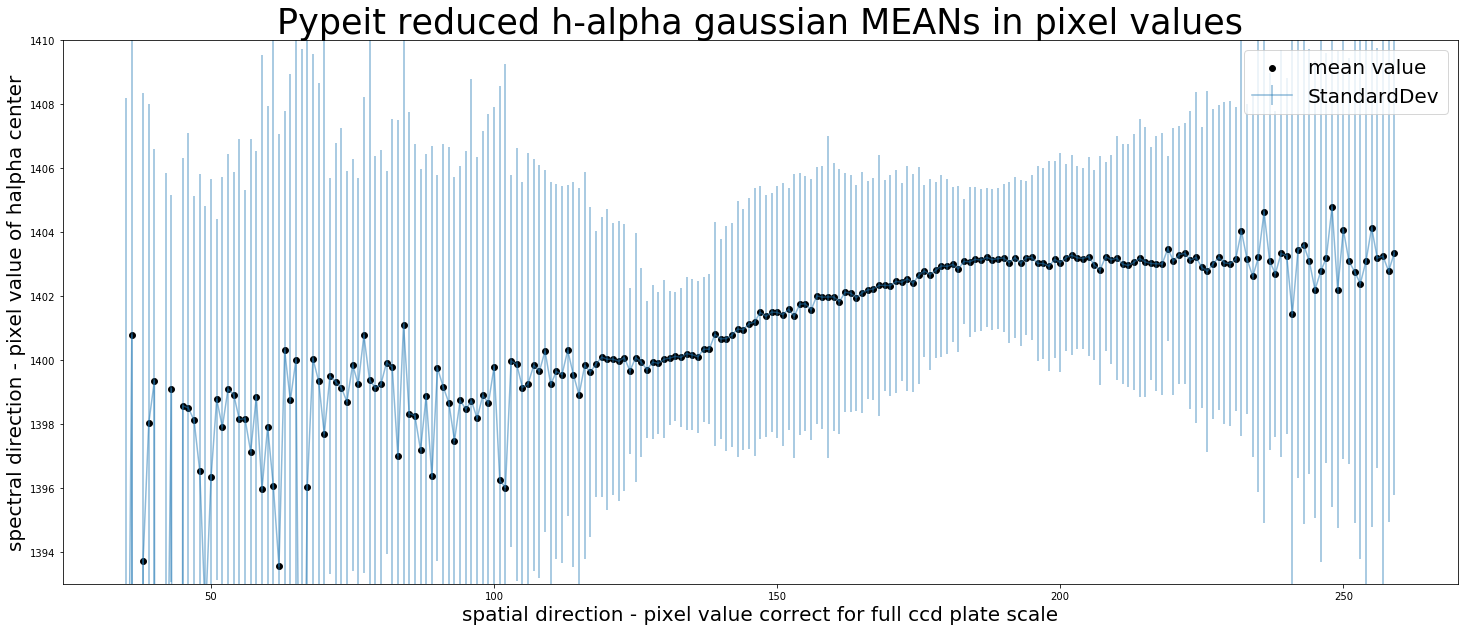

In [10]:
#plotting gauss means
plt.figure(figsize=(25,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of halpha center',fontsize=20)
plt.scatter(target_spacepix_fullccd,gauss_mean,color='k',s=35,label='mean value')
plt.errorbar(target_spacepix_fullccd,gauss_mean,yerr=stddev,label='StandardDev',alpha=.5)
plt.title('Pypeit reduced h-alpha gaussian MEANs in pixel values',fontsize=35)
plt.legend(fontsize=20)
plt.ylim(1393,1410);
# plt.ylim(1398,1415)
print('well that hump around x=130 in the gaussMAXs is from the stddev')

(1399, 1405)

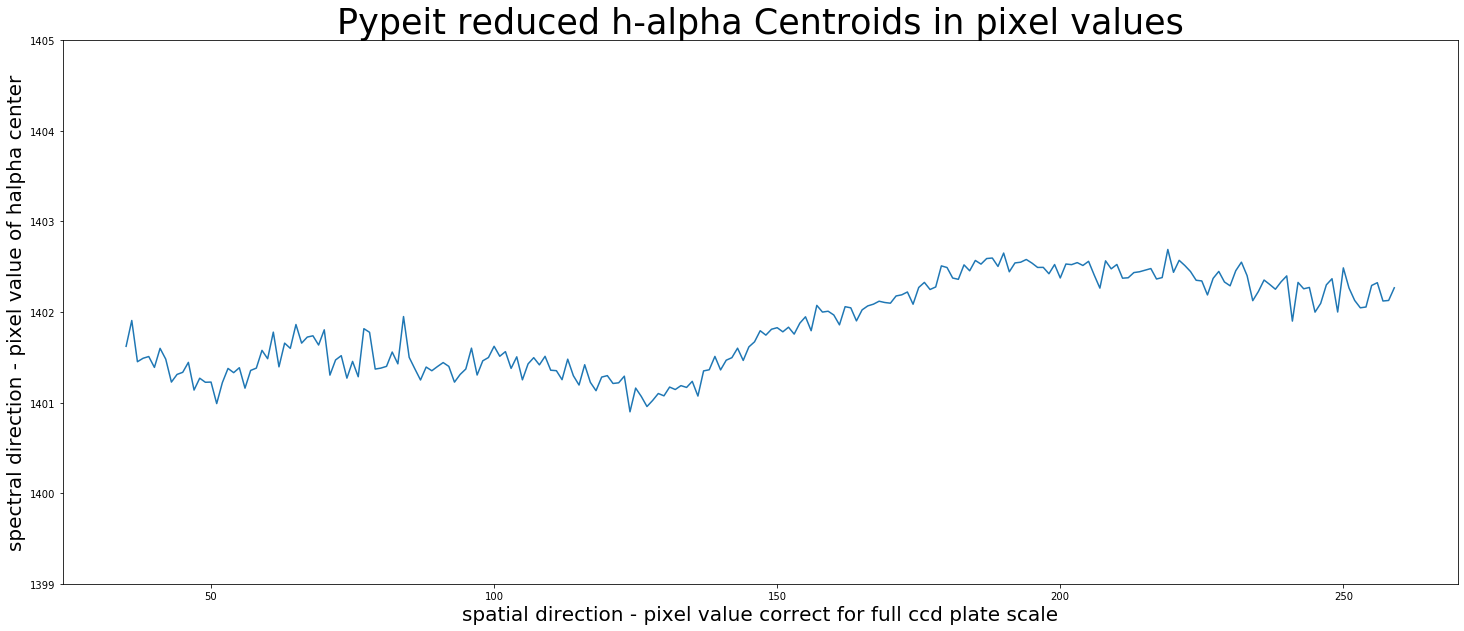

In [11]:
#plotting
plt.figure(figsize=(25,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of halpha center',fontsize=20)
plt.plot(target_spacepix_fullccd,centroid_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
plt.title('Pypeit reduced h-alpha Centroids in pixel values',fontsize=35)
#plt.ylim(1393,1407)
plt.ylim(1399,1405)

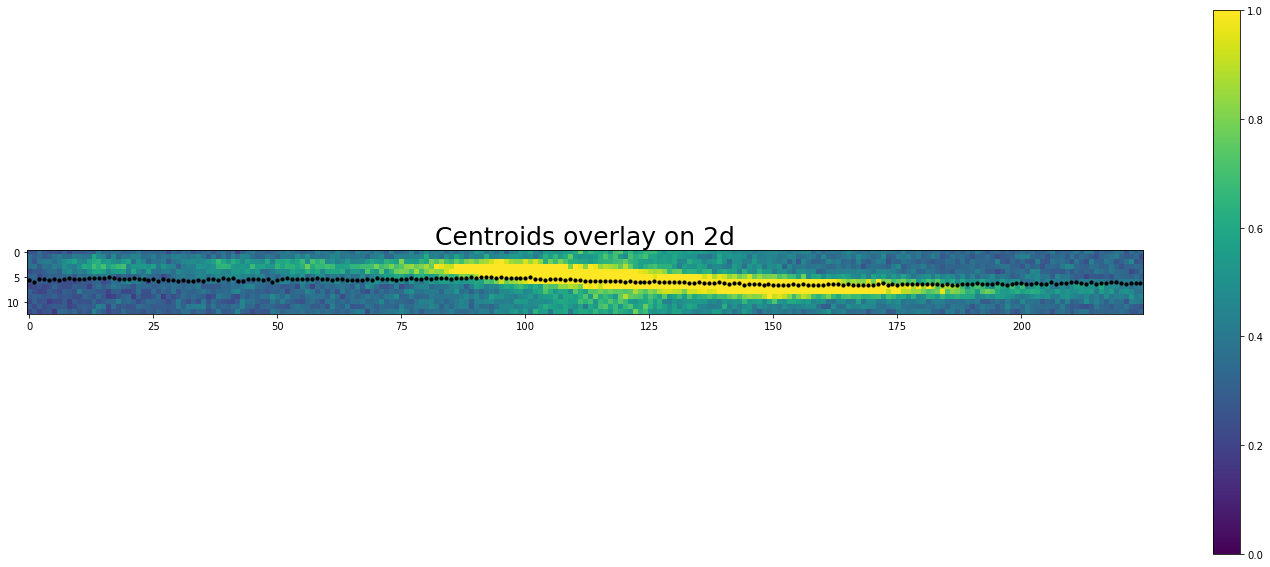

In [12]:
#centraoids overlay on 2d

#horizontal
plt.figure(figsize=(25,10))
plt.imshow(np.transpose(new_short), vmin=-10, vmax =200 ,cmap='viridis') #this is what went 'in' except transpose to make horizontal again
plt.scatter(target_spacepix_fullccd-35,centroid_specpix_fullccd-1396,color='k',s=10) #subtract b/c this is the halpha cutout, not full ccd pix range
plt.title('Centroids overlay on 2d',fontsize=25)
plt.colorbar();
#vertical
# plt.figure(figsize=(25,10))
# plt.imshow(new_short, vmin=-10, vmax =200 ,cmap='viridis') #this is what went 'in' except transpose to make horizontal again
# plt.scatter(centroid_specpix_fullccd-1396,target_spacepix_fullccd-35,color='k',s=3) #subtract b/c this is the halpha cutout, not full ccd pix range
# plt.title('Centroids overlay on 2d',fontsize=25)
# plt.colorbar();

(20, -10)

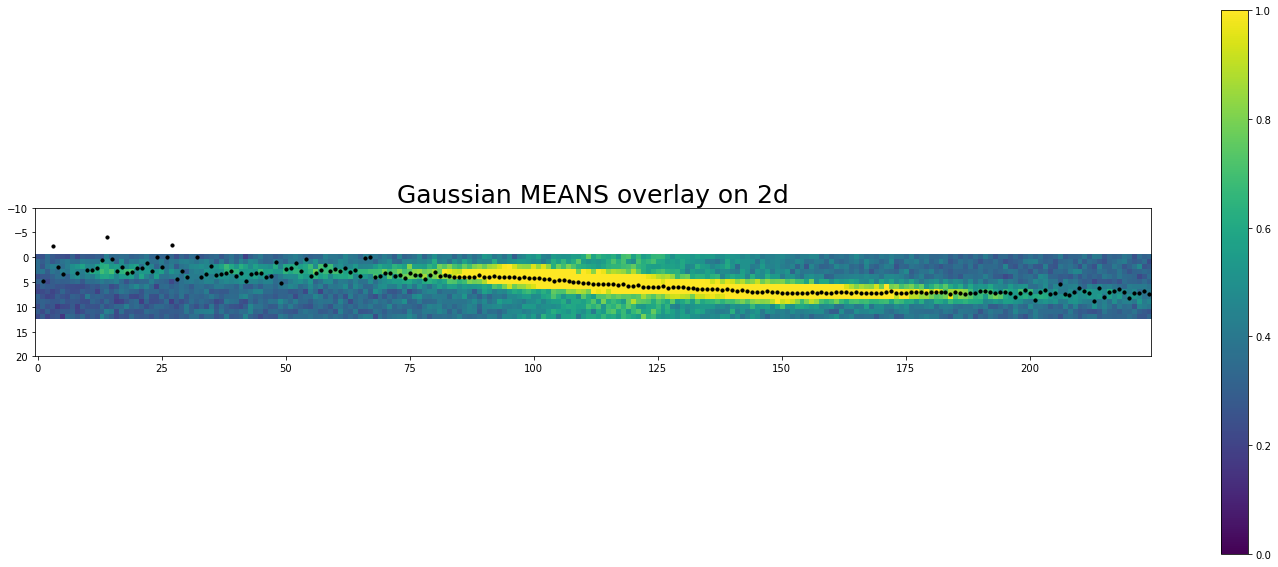

In [13]:
#centraoids overlay on 2d

#horizontal
plt.figure(figsize=(25,10))
plt.imshow(np.transpose(new_short), vmin=-10, vmax =200 ,cmap='viridis') #this is what went 'in' except transpose to make horizontal again
plt.scatter(target_spacepix_fullccd-35,gauss_mean-1396,color='k',s=10) #subtract b/c this is the halpha cutout, not full ccd pix range
plt.title('Gaussian MEANS overlay on 2d',fontsize=25)
plt.colorbar();
plt.ylim(20,-10) #some bad fits go super negative so need this
#vertical
# plt.figure(figsize=(25,10))
# plt.imshow(new_short, vmin=-10, vmax =200 ,cmap='viridis') #this is what went 'in' except transpose to make horizontal again
# plt.scatter(centroid_specpix_fullccd-1396,target_spacepix_fullccd-35,color='k',s=3) #subtract b/c this is the halpha cutout, not full ccd pix range
# plt.title('Centroids overlay on 2d',fontsize=25)
# plt.colorbar();

clearly some fits are super poor and went to absurdness so will need masking - but theres more poor fits with pypeit versions than mine


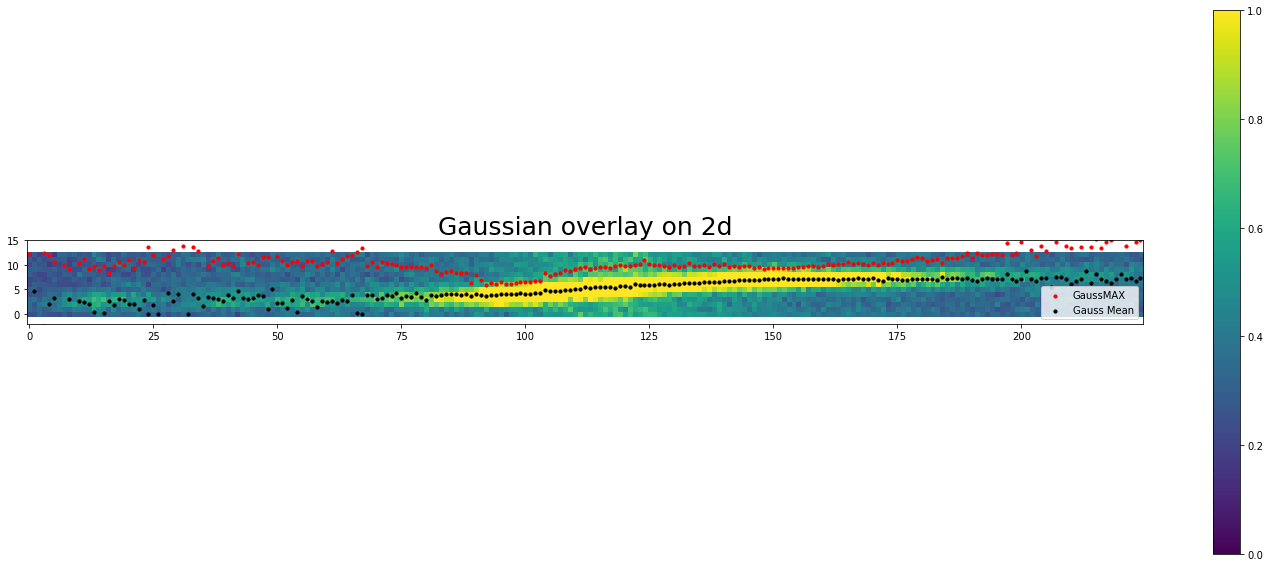

In [14]:
#gaussian overlay on 2d
#horizontal
plt.figure(figsize=(25,10))
plt.imshow(np.transpose(new_short), vmin=-10, vmax =200 ,cmap='viridis') #this is what went 'in' except transpose to make horizontal again
plt.scatter(target_spacepix_fullccd-35,gaussmax_specpix_fullccd-1396,color='r',s=10,label='GaussMAX') #subtract b/c this is the halpha cutout, not full ccd pix range
plt.scatter(target_spacepix_fullccd-35,gauss_mean-1396,color='k',s=10,label='Gauss Mean')
plt.legend()
plt.title('Gaussian overlay on 2d',fontsize=25)
plt.colorbar();
plt.ylim(-2,15);
#vertical
# plt.figure(figsize=(25,10))
# plt.imshow(new_short, vmin=-10, vmax =200 ,cmap='viridis') #this is what went 'in' 
# plt.scatter(gaussmax_specpix_fullccd-1396,target_spacepix_fullccd-35,color='r',s=3,label='GaussMAX')#subtract b/c this is the halpha cutout, not full ccd pix range
# plt.scatter(gauss_mean-1396,target_spacepix_fullccd-35,color='k',s=3,label='Gauss Mean')
# plt.legend()
# plt.title('Gaussian overlay on 2d',fontsize=25)
# plt.colorbar();
# plt.xlim(-2,15);
print('clearly some fits are super poor and went to absurdness so will need masking - but theres more poor fits with pypeit versions than mine')

## checking if background subtracted since centroid is still not tracing well over/under fitting

baseline emission seems to be at ~50....should straight subtract?


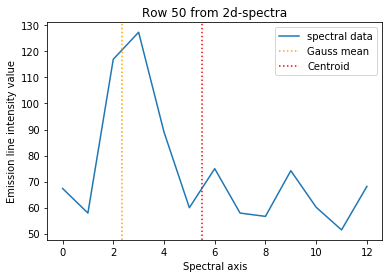

In [15]:
#
row = 50
plt.plot(np.arange(0,len(new_short[row]),1),new_short[row],label='spectral data')
# plt.scatter(gauss_mean[row]-1396,target_spacepix_fullccd[row]-35,label='Gauss mean')
# plt.scatter(centroid_specpix_fullccd[row]-1396,target_spacepix_fullccd[row]-35,label='Centroid')
plt.axvline(gauss_mean[row]-1396,color='orange',linestyle=':',label='Gauss mean')
plt.axvline(centroid_specpix_fullccd[row]-1396,color='r',ls=':',label='Centroid')

plt.legend()
plt.title('Row {} from 2d-spectra'.format(row))
plt.xlabel('Spectral axis');plt.ylabel('Emission line intensity value');
print('baseline emission seems to be at ~50....should straight subtract?')

# for 

In [16]:
new_short[100]

array([ 97.1705  ,  90.51903 , 188.53583 , 289.21985 , 390.5974  ,
       299.4378  , 187.97174 , 120.828316,  90.82463 ,  93.249725,
       103.08171 ,  92.0285  , 106.31672 ], dtype=float32)